# CS146 Final Project - Mahjong Statistics Prediction

In [16]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan

In [13]:
# Import dataset
raw_df = pd.read_csv("./dataset.csv", index_col=[0])
raw_df.head()

,time,rank,score
0,2022/4/17 01:59,1,40400
1,2022/4/17 01:21,2,27300
2,2022/4/17 00:39,3,23500
3,2022/4/16 18:30,2,20300
4,2022/4/16 17:51,4,-300


## Preprocessing

In [68]:
# create copy of df instance
df = raw_df

# Change time column from string to datetime
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,rank,score,7d_avg_score,7d_avg_rank
0,2022-04-17,1,40400,40400.0,1.0
1,2022-04-17,2,27300,33850.0,1.5
2,2022-04-17,3,23500,30400.0,2.0
3,2022-04-16,2,20300,27875.0,2.0
4,2022-04-16,4,-300,22240.0,2.4


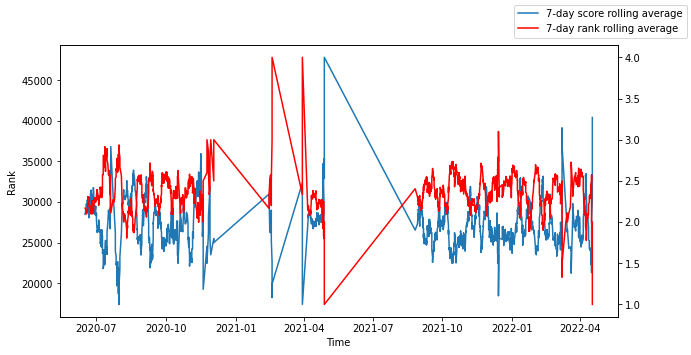

In [69]:
# Calculate weekly averages
df["7d_avg_score"] = df.rolling(window = '7D', on = 'time')['score'].mean()
df["7d_avg_rank"] = df.rolling(window = '7D', on = 'time')['rank'].mean()

# Plot data
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df['time'], df["7d_avg_score"], label = "7-day score rolling average")

ax2 = ax1.twinx()
ax2.plot(df['time'], df["7d_avg_rank"], color= "red",label = "7-day rank rolling average")
ax1.set_xlabel("Time")
ax1.set_ylabel("Score")
ax1.set_ylabel("Rank")
fig.legend()
plt.show()

In [41]:
# Write model 1
stan_code_1 = """
data {
    int<lower=0> N;
    vector[N] time;
    vector[N] score;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    score ~ normal(alpha + beta * time, sigma);
}
"""

In [63]:
x = df['time'].dt.to_pydatetime()

array([datetime.datetime(2022, 4, 17, 1, 59),
       datetime.datetime(2022, 4, 17, 1, 21),
       datetime.datetime(2022, 4, 17, 0, 39), ...,
       datetime.datetime(2020, 6, 18, 17, 40),
       datetime.datetime(2020, 6, 18, 17, 28),
       datetime.datetime(2020, 6, 16, 23, 51)], dtype=object)

In [ ]:
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'].to_pydatetime()

In [64]:

# Put our data in a dictionary
data = {
    'N': len(df['time'].dt.to_pydatetime()), 
    'time': df['time'].dt.to_pydatetime(), 
    'score': df['7d_avg_score'].to_dict()
}

# Compile the model
model_1 = stan.build(stan_code_1,data=data)

# Train the model and generate samples
results_1 = model_1.sampling(iter=1000, chains=4, warmup=500)
results_samples_1 = results_1.extract()["eta"]


TypeError: Object of type datetime is not JSON serializable

In [ ]:
print(results_1.stansummary())